# Leios simulation analysis at tag `leios-2025w19`

## Load packages

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Analysis of lifecycles and efficiencies

### Read the lifecycle results

In [2]:
lifecycle <- fread("results/lifecycle.csv.gz", stringsAsFactors=TRUE)
lifecycle[, `Kind`:=factor(`Kind`, levels=c("RB", "EB", "IB", "TX"))]
lifecycle[, `tps`:=factor(paste(`tps`, "tx/s"), levels=paste(c(1,3,10,30,100,300,1000), "tx/s"))]
lifecycle %>% summary

 simulator            tps         Kind               Item       
 rust:614045   1 tx/s   :   734   RB:   215   0        :     7  
               3 tx/s   :  2009   EB:   596   0-node-33:     7  
               10 tx/s  :  6603   IB:  6229   0-node-91:     7  
               30 tx/s  : 19684   TX:607005   1        :     7  
               100 tx/s : 67988               10       :     7  
               300 tx/s :228135               100      :     7  
               1000 tx/s:288892               (Other)  :614003  
    Size [B]        References      Created [s]       To IB [s]     
 Min.   :     6   Min.   : 0.000   Min.   :  0.00   Min.   :  1.13  
 1st Qu.:   437   1st Qu.: 0.000   1st Qu.: 62.87   1st Qu.: 90.82  
 Median :   941   Median : 1.000   Median :125.32   Median :223.13  
 Mean   :  3668   Mean   : 1.159   Mean   :194.75   Mean   :253.33  
 3rd Qu.:  2038   3rd Qu.: 2.000   3rd Qu.:317.32   3rd Qu.:407.13  
 Max.   :196608   Max.   :12.000   Max.   :600.00   Max.   :599.13

### Caveat

<font color="red">Beware that the plots below contain boundary effects that distort the statistics.</font>

### Size of persisted data

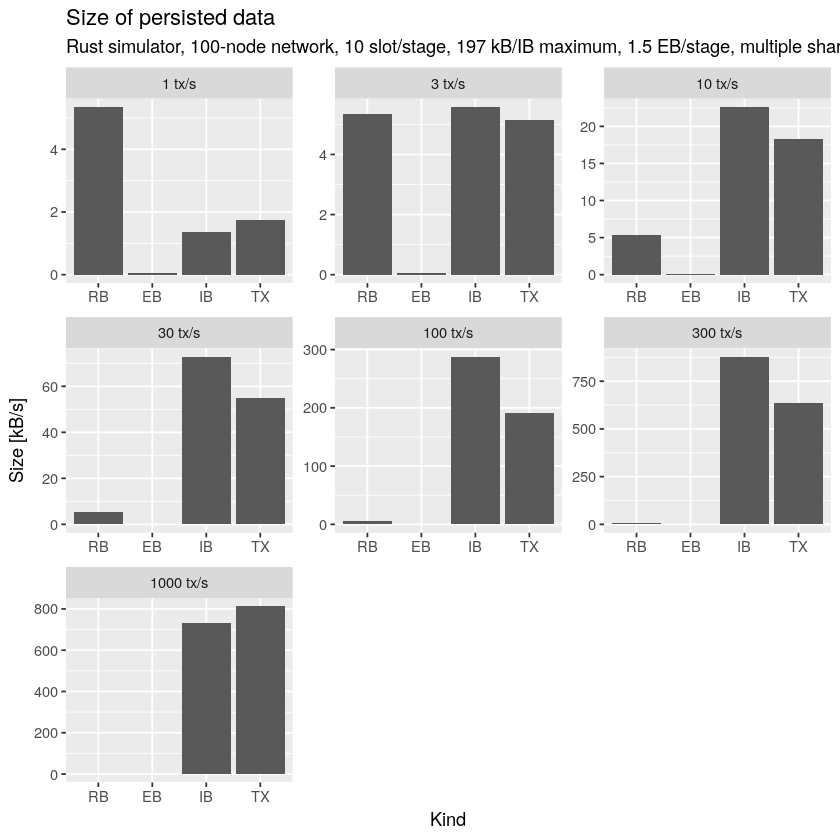

In [3]:
ggplot(
    lifecycle[, .(`Size [kB/s]`=sum(`Size [B]`)/1e3/600), .(`Kind`, `TPS`=`tps`)],
    aes(x=`Kind`, y=`Size [kB/s]`)
) + geom_bar(stat="identity") +
    facet_wrap(`TPS` ~ ., scales="free") +
    ggtitle(
        "Size of persisted data",
        subtitle="Rust simulator, 100-node network, 10 slot/stage, 197 kB/IB maximum, 1.5 EB/stage, multiple shards"
    )

In [4]:
ggsave("plots/sizes.png", units="in", dpi=150, width=8, height=6)

In [5]:
ggsave("plots/sizes.svg", units="in", dpi=150, width=8, height=6)

### Spatial efficiency

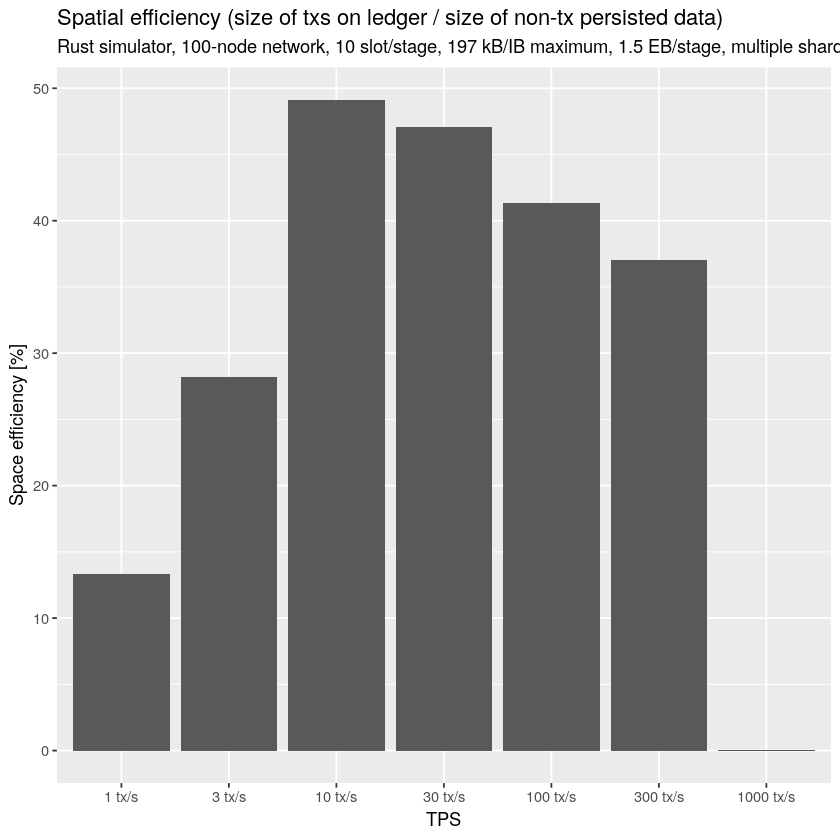

In [6]:
ggplot(
    lifecycle[
        `Kind` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`TPS`=`tps`)
    ][
        lifecycle[
            `Kind` != "TX", 
            .(`Non-tx size [B]`=sum(`Size [B]`)), 
            .(`TPS`=`tps`)
        ],
        on=c("TPS")
    ][, .(`TPS`, `Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`)],
    aes(x=`TPS`, y=`Space efficiency [%]`)
) +
    geom_bar(stat="identity") +
    ggtitle(
        "Spatial efficiency (size of txs on ledger / size of non-tx persisted data)",
        subtitle="Rust simulator, 100-node network, 10 slot/stage, 197 kB/IB maximum, 1.5 EB/stage, multiple shards"
    )

In [7]:
ggsave("plots/space-efficiency.png", units="in", dpi=150, width=8, height=6)

In [8]:
ggsave("plots/space-efficiency.svg", units="in", dpi=150, width=8, height=6)

### Time to reach the ledger

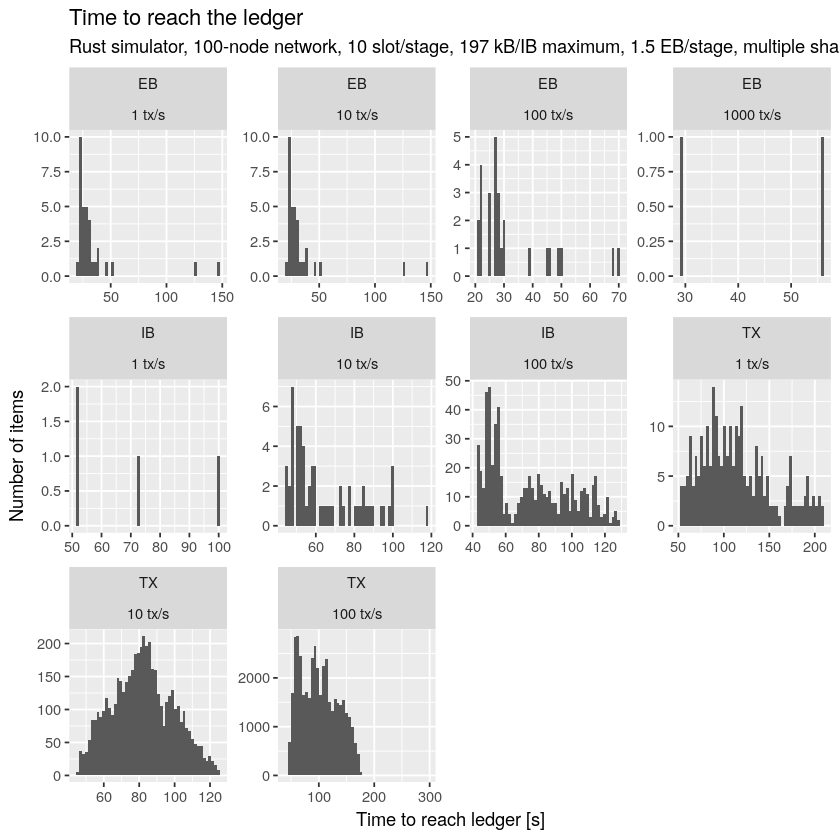

In [9]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB", "EB") & 
        `tps` %in% c("1 tx/s", "10 tx/s", "100 tx/s", "1000 tx/s") & 
        !is.na(`To RB [s]`), 
        .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
        .(`Kind`, `tps`)
    ],
    aes(x=`Time to reach ledger [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(`Kind` ~ `tps`, scales="free", ncol=4) +
    ylab("Number of items") +
    ggtitle(
        "Time to reach the ledger",
        subtitle="Rust simulator, 100-node network, 10 slot/stage, 197 kB/IB maximum, 1.5 EB/stage, multiple shards"
    )

In [10]:
ggsave("plots/reach-rb.png", units="in", dpi=150, width=8, height=6)

In [11]:
ggsave("plots/reach-rb.svg", units="in", dpi=150, width=8, height=6)

### Time to reach an EB

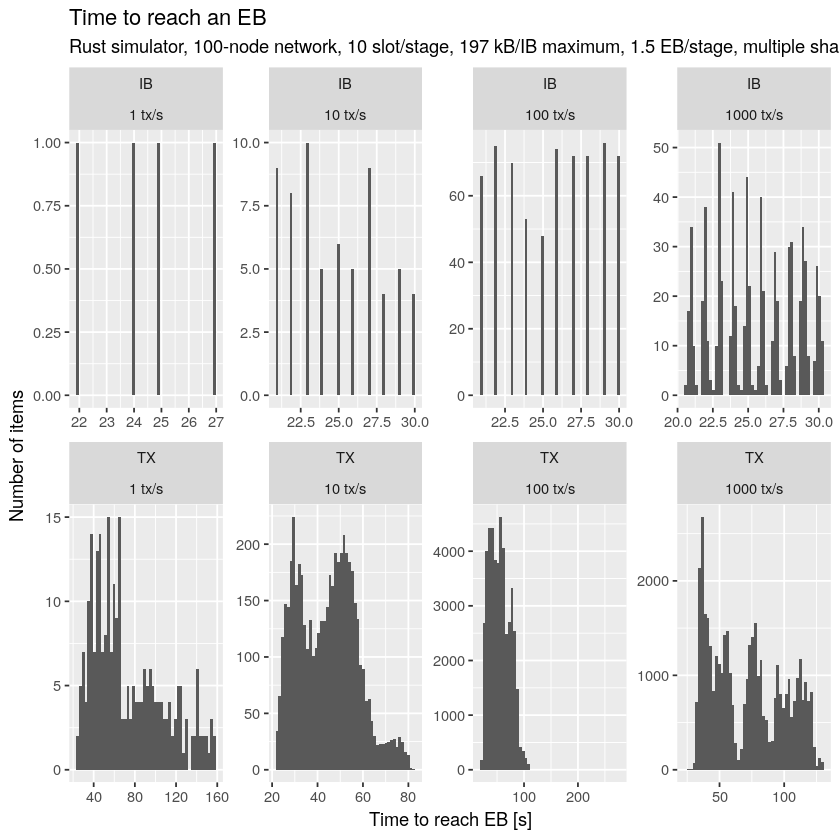

In [12]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB") & 
        `tps` %in% c("1 tx/s", "10 tx/s", "100 tx/s", "1000 tx/s") & 
        !is.na(`To EB [s]`), 
        .(`Time to reach EB [s]`=`To EB [s]`-`Created [s]`), 
        .(`Kind`, `tps`)
    ],
    aes(x=`Time to reach EB [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(`Kind` ~ `tps`, scales="free", ncol=4) +
    ylab("Number of items") +
    ggtitle(
        "Time to reach an EB",
        subtitle="Rust simulator, 100-node network, 10 slot/stage, 197 kB/IB maximum, 1.5 EB/stage, multiple shards"
    )

In [13]:
ggsave("plots/reach-eb.png", units="in", dpi=150, width=8, height=6)

In [14]:
ggsave("plots/reach-eb.svg", units="in", dpi=150, width=8, height=6)

### Time to reach an IB

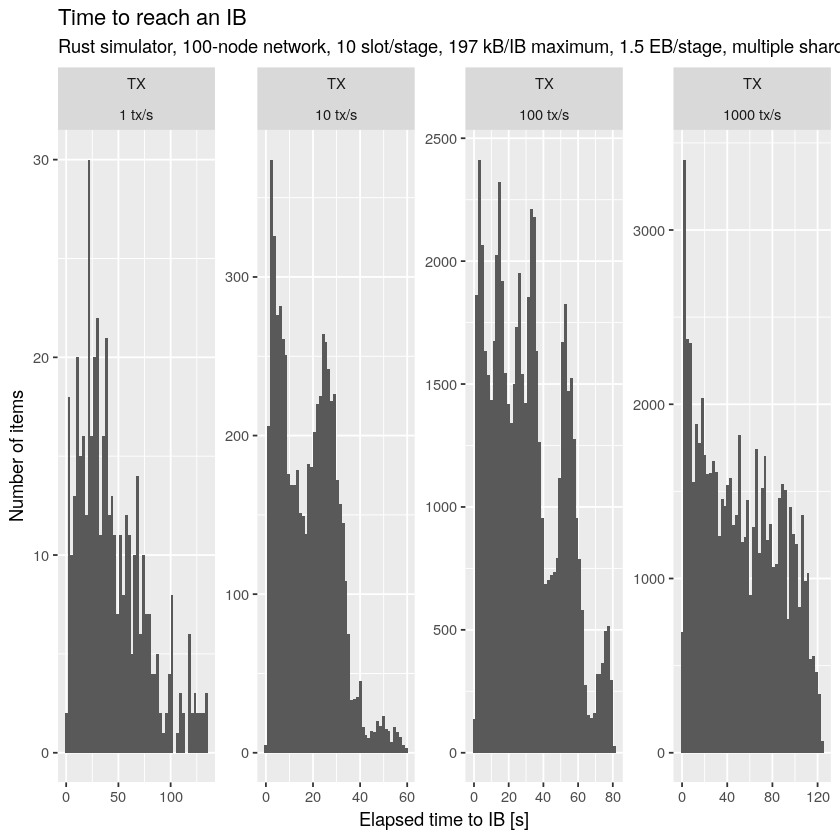

In [15]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX") & 
        `tps` %in% c("1 tx/s", "10 tx/s", "100 tx/s", "1000 tx/s") & 
        !is.na(`To IB [s]`), 
        .(`Elapsed time to IB [s]`=`To IB [s]`-`Created [s]`), 
        .(`Kind`, `tps`)],
    aes(x=`Elapsed time to IB [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(`Kind` ~ `tps`, scales="free", ncol=4) +
    ylab("Number of items") +
    ggtitle(
        "Time to reach an IB",
        subtitle="Rust simulator, 100-node network, 10 slot/stage, 197 kB/IB maximum, 1.5 EB/stage, multiple shards"
    )

In [16]:
ggsave("plots/reach-ib.png", units="in", dpi=150, width=8, height=6)

In [17]:
ggsave("plots/reach-ib.svg", units="in", dpi=150, width=8, height=6)

### Number of references

A *reference* is one of the following:

- A transaction is included in an IB.
- An IB is referenced by an EB.
- An EB is referenced by another EB.

In an efficient Leios, the number of references for each data item would be one.

- *Zero references* indicates that the item was not used.
- *Two or more references* indicates that duplication has occurred.

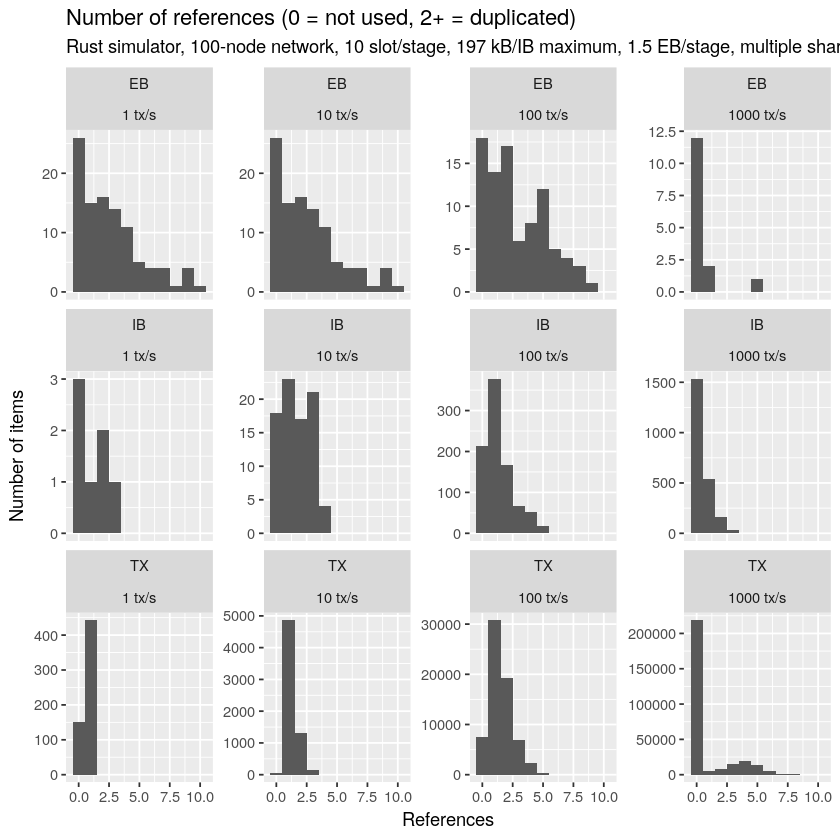

In [18]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB", "EB") &
        `tps` %in% c("1 tx/s", "10 tx/s", "100 tx/s", "1000 tx/s")
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_wrap(`Kind` ~ `tps`, scales="free_y", ncol=4) +
    ylab("Number of items") +
    ggtitle(
        "Number of references (0 = not used, 2+ = duplicated)",
        subtitle="Rust simulator, 100-node network, 10 slot/stage, 197 kB/IB maximum, 1.5 EB/stage, multiple shards"
    )

In [19]:
ggsave("plots/references.png", units="in", dpi=150, width=8, height=6)

In [20]:
ggsave("plots/references.svg", units="in", dpi=150, width=8, height=6)

### Temporal efficiency

In [21]:
toElapsed <- function(created, toRb, inRb) {
    if (!is.na(toRb))
        toRb - created
    else if (!is.na(inRb))
        inRb - created
    else
        NA
}

In [22]:
outcomes <- lifecycle[
    `Kind` == "TX",
    .(
        `Submitted [minute]`=factor(ceiling(`Created [s]`/60)), 
        `Time to reach ledger [s]`=mapply(toElapsed, `Created [s]`, `To RB [s]`, `In RB [s]`)
    ), .(
        `TPS`=`tps`
    )
][order(`TPS`, `Submitted [minute]`, `Time to reach ledger [s]`)]

In [23]:
totals <- outcomes[, .(`Total`=.N, `Lost`=sum(is.na(`Time to reach ledger [s]`))), .(`TPS`, `Submitted [minute]`)]

#### Transactions reaching the ledger

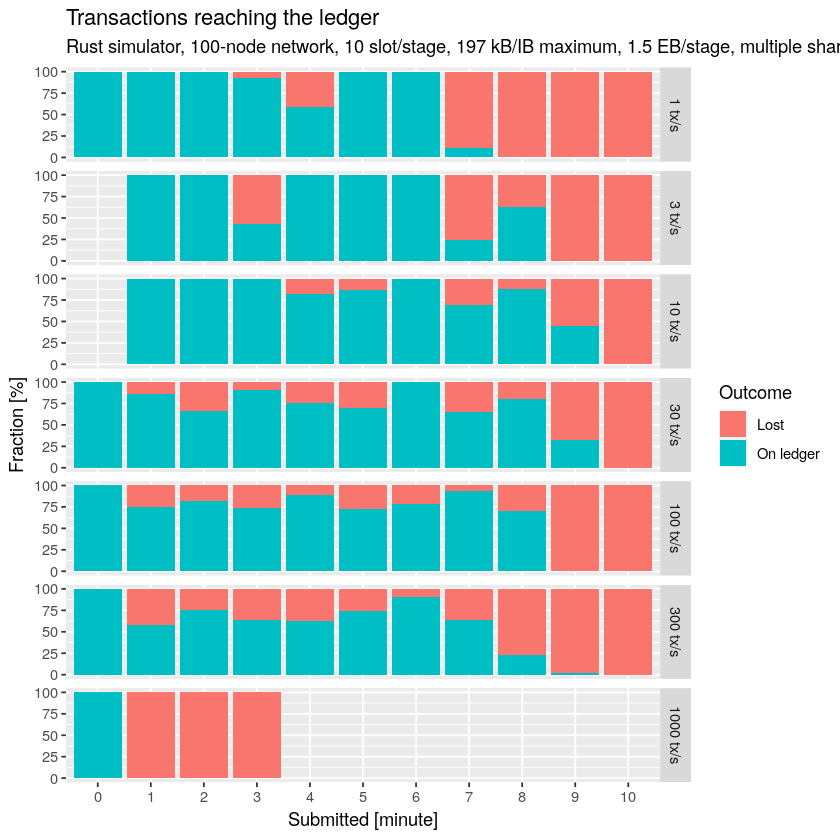

In [24]:
ggplot(
    melt(
        totals[, .(`On ledger`=1-`Lost`/`Total`, `Lost`=`Lost`/`Total`), .(`TPS`, `Submitted [minute]`)],
        id.vars=c("TPS", "Submitted [minute]"),
        variable.name="Outcome",
        value.name="Fraction"
    )[, .(
        `TPS`, 
        `Submitted [minute]`, 
        `Outcome`=factor(`Outcome`,levels=c("Lost","On ledger")), 
        `Fraction [%]`=100*`Fraction`
    )],
    aes(x=`Submitted [minute]`, y=`Fraction [%]`, fill=`Outcome`)
) +
    geom_bar(stat="identity") +
    facet_grid(`TPS` ~ .) +
    ggtitle(
        "Transactions reaching the ledger",
        subtitle="Rust simulator, 100-node network, 10 slot/stage, 197 kB/IB maximum, 1.5 EB/stage, multiple shards"
    )

In [25]:
ggsave("plots/temporal-efficiency-bar.png", units="in", dpi=150, width=8, height=6)

In [26]:
ggsave("plots/temporal-efficienty-bar.svg", units="in", dpi=150, width=8, height=6)

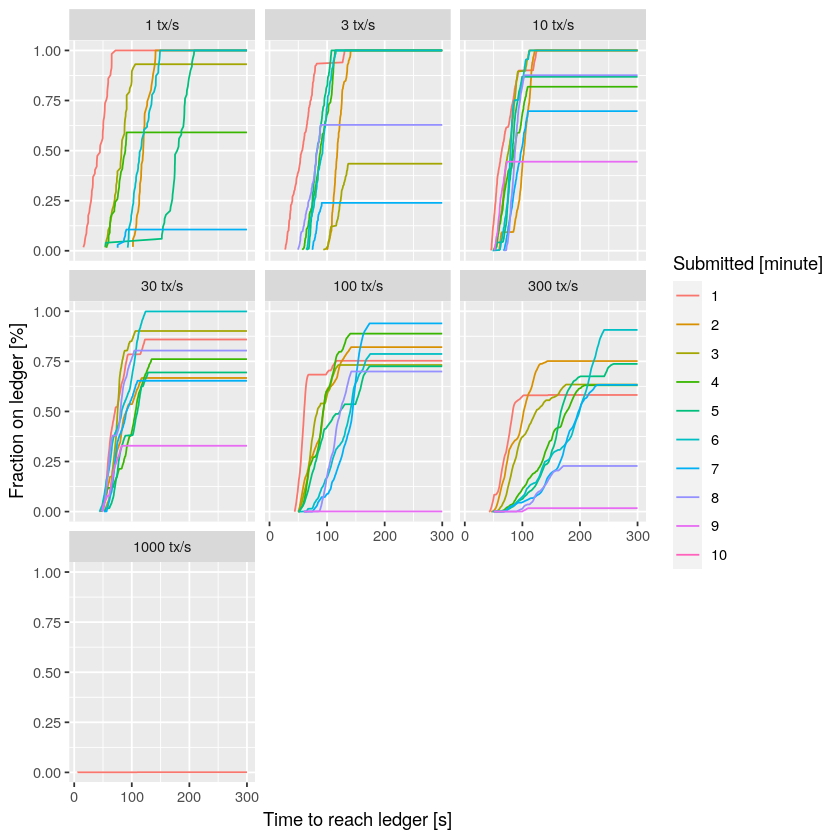

In [27]:
ggplot(
    rbind(
        totals[
            outcomes[!is.na(`Time to reach ledger [s]`), .(`Cumulative total`=1:length(`Time to reach ledger [s]`), `Time to reach ledger [s]`), .(`TPS`, `Submitted [minute]`)],
            on=c("TPS", "Submitted [minute]")
        ][,
            .(`Time to reach ledger [s]`, `Fraction on ledger [%]`=`Cumulative total`/`Total`),
            .(`TPS`, `Submitted [minute]`)
        ],
        totals[, .(`Fraction on ledger [%]`=1-`Lost`/`Total`, `Time to reach ledger [s]`=300), .(`TPS`, `Submitted [minute]`)]
    )[`Submitted [minute]` != 0],
    aes(x=`Time to reach ledger [s]`, y=`Fraction on ledger [%]`, color=`Submitted [minute]`)
) +
    geom_line() +
    facet_wrap(`TPS` ~ .)

In [28]:
ggsave("plots/temporal-efficiency-timeseries.png", units="in", dpi=150, width=8, height=6)

In [29]:
ggsave("plots/temporal-efficienty-timeseries.svg", units="in", dpi=150, width=8, height=6)